## THIS IS THE FIRST NOTEBOOK FOR THE FINAL PROJECT

In [1]:
# A. downloads data from Oanda (2. Connect to the Oanda API and download data)
#    and saves to an HDF5 file (3. Store dataseries fulldata with HDF5) called
#   'data.h5'
# B. to avoid having to download data from Oanda start running notebook
#    from number (4. start with data saved from HDF5 file) which accesses
#    the data previously saved in (2. Connect to the Oanda API and download data).
# C. calculates features (5. Calculate features for data) - RSI and MACD using
#    functions and then...
# D. calculates lagged variables (6. Creates lagged data for the features RSI, 
#    MACD and Returns) for RSI, MACD and Returns
# E. (7. Create a short and long term momentum signal) also creates two 
#    momentum features (short and long term)
# F. Finally all the data and features are saved in a file 'data_
#    features.h5' for later use in the backtesting notebooks (8. store the 
#    data and features in an HDF5 file 'data_features.h5')

## 1. Imports

In [2]:
import sys
sys.path.insert(0, '/root/')

In [3]:
from tpqoa import tpqoa
import numpy as np
import pandas as pd
import tables as tb
import tstables as tstb
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## 2. Connect to the Oanda API and download data

In [4]:
# connects to Oanda and saves 4 months (jan 18 - Apr 18) of 
# AUDUSD data concatenates the four months into a single pandas
# dataseries called "fulldata"

In [5]:
oanda = tpqoa('/root/pyalgo.cfg')

In [6]:
instrument_1 = 'AUD_USD'

In [7]:
month1 = oanda.get_history(instrument_1,
                          start = '2017-12-31',
                          end = '2018-2-1',
                          granularity = 'M10',
                          price = 'A')

In [8]:
month2 = oanda.get_history(instrument_1,
                          start = '2018-2-1',
                          end = '2018-3-1',
                          granularity ='M10',
                          price = 'A')

In [9]:
month3 = oanda.get_history(instrument_1,
                        start = '2018-3-1',
                        end = '2018-3-31',
                        granularity = 'M10',
                        price = 'A')

In [10]:
month4 = oanda.get_history(instrument_1,
                        start = '2018-3-31',
                        end = '2018-4-30',
                        granularity = 'M10',
                        price = 'A')

In [11]:
month1cls = month1['c']
month2cls = month2['c']
month3cls = month3['c']
month4cls = month4['c']

In [12]:
seg_data = [month1cls, month2cls, month3cls, month4cls]

In [13]:
fulldata = pd.concat(seg_data)

# 3. Store dataseries 'fulldata' with HDF5

In [14]:
# writes the pandas dataseries fulldata to an HDF5 file

In [15]:
h5 = pd.HDFStore('/root/pyalgocourse/final_project/data.h5','w')

In [16]:
h5['data'] = fulldata

In [17]:
h5

<class 'pandas.io.pytables.HDFStore'>
File path: /root/pyalgocourse/final_project/data.h5
/data            series       (shape->[12108])

In [18]:
ls -n data.*

-rw-r--r-- 1 0 0 198816 May 27 02:23 data.h5


In [19]:
h5.close()

## 4. Start with data saved from HDF5 file

In [20]:
# to avoid calling the data from Oanda the notebook can
# be run from here using data previously stored in HDF5 file
# in number (3) above

In [21]:
import pandas as pd

In [22]:
h5 = pd.HDFStore('/root/pyalgocourse/final_project/data.h5','r')

In [23]:
fulldata_copy = h5['data']

In [24]:
h5.close()

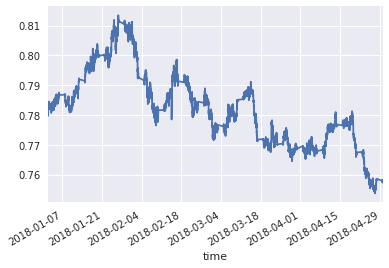

In [25]:
fulldata_copy.plot();

## 5. Calculate features for data

In [26]:
# a function to calulate the RSI Index.

def relative_strength(data, n = 21):
    '''Creates RSI feature -
    initial RSI value created here'''   
    abchange = (data - data.shift(1)) # calculate absolute daily change
    rsperiod = abchange[:n + 1] 
    upday = rsperiod[rsperiod >= 0].sum() / n # in the RSI period what is the up day change
    dnday = -rsperiod[rsperiod < 0].sum() / n # in the RSI period ehat is the down day change
    rs = upday / dnday # up day change/down day change ratio
    rsi = np.zeros_like(data)
    rsi[:n] = 100. - (100. / ( 1. + rs)) # formula for RSI Index calculation
    
    '''calculates subsequent change in RSI values'''
    for i in range(n, len(data)):
        abchg = abchange[i - 1]
        if abchg > 0:
            upval = abchg
            dnval = 0
        else:
            upval = 0
            dnval = abs(abchg)
        
        # iterate through each daily change proportionally adding it
        # to the respective RSI period cahnge
        upday = (upday * (n - 1) + upval) / n
        dnday = (dnday * (n - 1) + dnval) / n
        
        rs = upday / dnday # up day change/down day change ratio
        rsi[i] = 100. - (100. / ( 1. + rs)) # formula for RSI Index calculation
        
    
    rsi = pd.DataFrame(rsi)
    rsi.index = fulldata_copy.index
    rsi.columns = ['RSI']
    return rsi # return the RSI Index value calculated
    

In [27]:
# run function 'relative_strength' to create RSI values
# for the dataseries
rsi = relative_strength(fulldata_copy)

In [28]:
fulldata_copy = pd.DataFrame(fulldata_copy)

In [29]:
fulldata_copy['RSI'] = rsi['RSI']
fulldata_copy.columns = ['AUDUSD','RSI']

In [30]:
fulldata_copy.head()

,AUDUSD,RSI
time,,
2018-01-01 22:00:00,0.78072,63.131313
2018-01-01 22:10:00,0.78067,63.131313
2018-01-01 22:20:00,0.78069,63.131313
2018-01-01 22:30:00,0.78054,63.131313
2018-01-01 22:40:00,0.78083,63.131313


In [31]:
# a function to calulate the MACD Index.

def macd(data, slow = 26, fast = 12, signal = 9):
    # calculate respective fast and slow exponential moving 
    # averages (ema)
    ema_fast = data.ewm(span = fast).mean()
    ema_slow = data.ewm(span = slow).mean()
    # MACD line is slow m.a. minus fast m.a.
    macd_line = ema_slow - ema_fast
    # signal line is 9 day ema of macd line
    sig_line = macd_line.ewm(span = signal).mean()
    # macd histogram is the macd line minus the 
    # signal line
    macd_hist = macd_line - sig_line
    macd_hist = pd.DataFrame(macd_hist)
    macd_hist.columns = ['MACD']
    return macd_hist

In [32]:
# run function 'macd' to create macd values
# for the dataseries
macd = macd(fulldata_copy['AUDUSD'])

In [33]:
fulldata_copy['MACD'] = macd['MACD']

In [34]:
fulldata_copy.head()

,AUDUSD,RSI,MACD
time,,,
2018-01-01 22:00:00,0.78072,63.131313,0.000000e+00
2018-01-01 22:10:00,0.78067,63.131313,4.985755e-07
2018-01-01 22:20:00,0.78069,63.131313,1.097535e-07
2018-01-01 22:30:00,0.78054,63.131313,3.546554e-06
2018-01-01 22:40:00,0.78083,63.131313,-3.699540e-06


In [35]:
# calulate the daily returns for the dataseries
fulldata_copy['Returns'] = np.log(fulldata_copy['AUDUSD'] / fulldata_copy['AUDUSD'].shift(1))

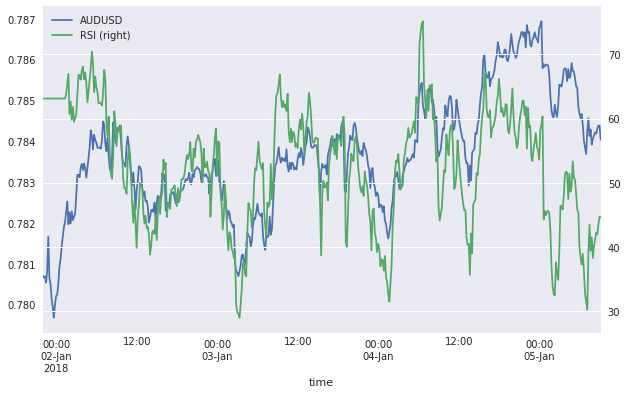

In [36]:
# plot AUDUSD vs its RSI Index
fulldata_copy[['AUDUSD','RSI']][:500].plot(figsize=(10,6),secondary_y = 'RSI');

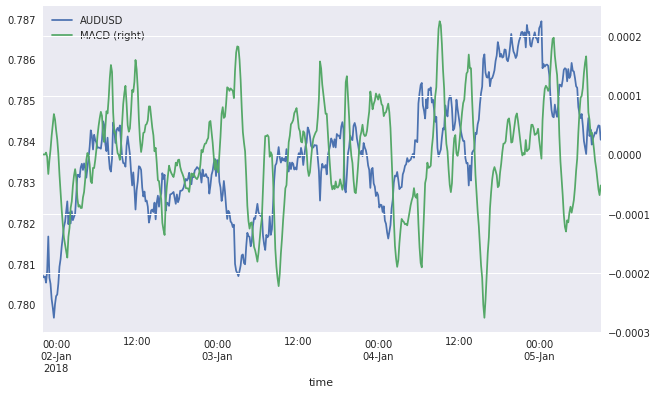

In [37]:
# Plot AUDUSD vs its MACD Histogram (plotted as a line)
fulldata_copy[['AUDUSD','MACD']][:500].plot(figsize=(10,6),secondary_y = 'MACD');

## 6. Creates lagged data for the features RSI, MACD and Returns

In [38]:
# This cell created lagged data for the features, the loop takes
# each feature e.g. RSI, MACD,... and creates lag 1 day, 2 day to 
# result in RSI_lag_1, RSI_lag_2,...,MACD_lag_1,...
lags = 29
features = fulldata_copy.columns
new_features = features.drop('AUDUSD')
cols = []
for feat in new_features:
    for lags in range(1, lags + 1):
        col = '%s_lag_%d' % (feat, lags)
        fulldata_copy[col] = fulldata_copy[feat].shift(lags)
        cols.append(col)

In [39]:
fulldata_copy.tail()

,AUDUSD,RSI,MACD,Returns,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,...,Returns_lag_20,Returns_lag_21,Returns_lag_22,Returns_lag_23,Returns_lag_24,Returns_lag_25,Returns_lag_26,Returns_lag_27,Returns_lag_28,Returns_lag_29
time,,,,,,,,,,,,,,,,,,,,,
2018-04-29 23:10:00,0.75740,49.180254,0.000114,-0.000172,50.540744,51.752726,55.730185,58.112165,57.114627,56.746750,...,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594,0.000079
2018-04-29 23:20:00,0.75728,47.251147,0.000123,-0.000158,49.180254,50.540744,51.752726,55.730185,58.112165,57.114627,...,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594
2018-04-29 23:30:00,0.75745,45.520534,0.000113,0.000224,47.251147,49.180254,50.540744,51.752726,55.730185,58.112165,...,-0.000040,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449
2018-04-29 23:40:00,0.75760,48.335277,0.000091,0.000198,45.520534,47.251147,49.180254,50.540744,51.752726,55.730185,...,0.000106,-0.000040,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198
2018-04-29 23:50:00,0.75740,50.695350,0.000086,-0.000264,48.335277,45.520534,47.251147,49.180254,50.540744,51.752726,...,-0.000013,0.000106,-0.000040,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119


## 7. Create a short and long term momentum signal

In [40]:
# creates twp momentum signals MOM1 and MOM2. The signal is 1 is the momentum for
# the signal period is positive and 0 is it is negative
fulldata_copy['MOM1'] = np.where(fulldata_copy['Returns'].rolling(10).mean() > 0, 1, 0)
fulldata_copy['MOM1'] = fulldata_copy['MOM1'].shift(1)
cols.append('MOM1')
fulldata_copy['MOM2'] = np.where(fulldata_copy['Returns'].rolling(50).mean() > 0, 1, 0)
fulldata_copy['MOM2'] = fulldata_copy['MOM2'].shift(1)
cols.append('MOM2')

In [41]:
fulldata_copy.dropna(inplace = True)

In [42]:
fulldata_copy.head()

,AUDUSD,RSI,MACD,Returns,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,...,Returns_lag_22,Returns_lag_23,Returns_lag_24,Returns_lag_25,Returns_lag_26,Returns_lag_27,Returns_lag_28,Returns_lag_29,MOM1,MOM2
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 03:00:00,0.78267,60.669419,-0.000039,0.000562,60.094516,59.531142,61.816813,59.812965,62.630244,60.738574,...,-0.000474,-0.000192,-0.001293,0.001075,0.000371,-0.000192,0.000026,-0.000064,1.0,0.0
2018-01-02 03:10:00,0.78318,63.690322,-0.000074,0.000651,60.669419,60.094516,59.531142,61.816813,59.812965,62.630244,...,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,0.000371,-0.000192,0.000026,1.0,0.0
2018-01-02 03:20:00,0.78318,66.794347,-0.000088,0.000000,63.690322,60.669419,60.094516,59.531142,61.816813,59.812965,...,-0.000321,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,0.000371,-0.000192,1.0,0.0
2018-01-02 03:30:00,0.78312,66.794347,-0.000085,-0.000077,66.794347,63.690322,60.669419,60.094516,59.531142,61.816813,...,0.000423,-0.000321,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,0.000371,1.0,0.0
2018-01-02 03:40:00,0.78336,66.061838,-0.000090,0.000306,66.794347,66.794347,63.690322,60.669419,60.094516,59.531142,...,0.000256,0.000423,-0.000321,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,1.0,0.0


# 8. store the data and features in an HDF5 file 'data_features.h5'

In [43]:
# create a new HDF5 file to store the full datas plus the lagged
# features that we have calculated.

In [44]:
h6 = pd.HDFStore('/root/pyalgocourse/final_project/data_features.h5','w')

In [45]:
h6['data'] = fulldata_copy

In [46]:
h6

<class 'pandas.io.pytables.HDFStore'>
File path: /root/pyalgocourse/final_project/data_features.h5
/data            frame        (shape->[12078,93])

In [47]:
ls -n data.*

-rw-r--r-- 1 0 0 198816 May 27 02:23 data.h5


In [48]:
h6.close()

## **NOW GO TO NOTEBOOK -> TWO_backtest_initial.ipynb**